In [1]:
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot
from nig import NiG
from scipy.io import loadmat

/usr/lib/python3/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Konstrukce a online bayesovský odhad AR modelu

V tomto příkladu se budeme zabývat průmyslovými daty, konkrétně měřeními a predikcemi válcovací štěrbiny v soustavě pro válcování plechů. Budeme používat AR model, zkusíme různé řády. S výhodou využijeme online update apriorní informace, která bude reprezentována normální-inverzní gama distribucí.

Nejprve nahrajeme data uložená v souboru `Gi.mat`, tedy v matlabovském formátu. Jedná se o matlabí strukturu. Do proměnné `ndat` uložte rozsah dat.

In [2]:
datafile = loadmat('Gi.mat')
rolling_data = datafile['CDsel']

start = 300
end = 850
data = rolling_data[start:end,10]
ndat = data.size

Pomocí funkce `tsplot` vykreslíme data a ACF a PACF. Interpretujte grafy.

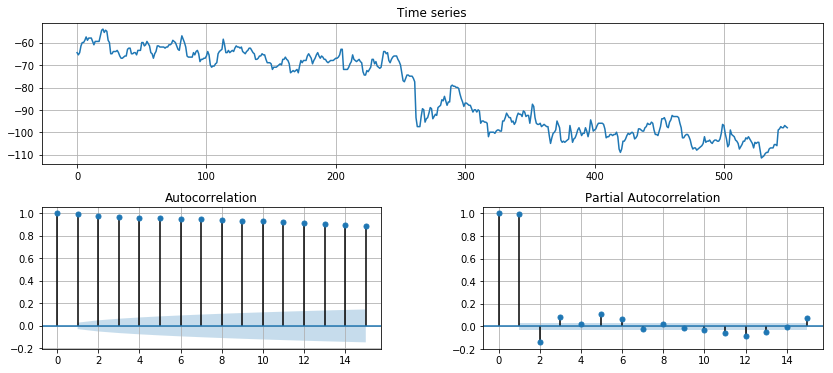

In [3]:
tsplot(data)

V proměnné `ARorder` bude uložen řád modelu. Matice `xi0` a skalár `nu0` definují parametry iniciální apriorní NiG distribuce.

In [4]:
ARorder = 4
xi0 = np.eye(ARorder+2) * 0.1
xi0[0,0] = 0.01
nu0 = 10

ar = NiG(xi0, nu0)

Nyní nás čeká asi nejnáročnější část. S každým příchozím měřením - datem - $X_t$ musíme:

- udělat predikci budoucí hodnoty $X_{t+1} = \hat{\beta}^\intercal [1, X_{t}, \ldots, X_{t-p+1}]^\intercal$, kde $p$ je řád modelu a ve vektoru máme schovaný celý regresor. Ten sestavíme z proměnné `data` vybráním podstatných prvků, následným otočením funkcí `np.flip` a vložením jedničky pomocí `np.insert`. Odhad beta nalezneme v `ar.beta_hat`.
- updatovat apriorní distribuci metodou `ar.update(xt, regressor)`, kde `xt` je **aktuální měření** a `regressor` je regresor $[1, X_{t-1},\ldots,X_{t-p}]^\intercal$, tedy o jednu posunutý oproti předchozímu bodu. Tedy použijeme stejný postup, jen na jinak posunutá data.

In [5]:
pred = []
for t in range(ndat):
    if t < ARorder or t == ndat:
        pred.append(0)
        continue
    
    data_for_pred = np.flip(data[t-ARorder+1:t+1], 0)
    pred.append(np.dot(ar.beta_hat, np.insert(data_for_pred, 0, 1)))
    
    regressor = np.insert(np.flip(data[t-ARorder:t],0), 0, 1)
    xt = data[t]
    ar.update(xt, regressor)
    ar.log()

V proměnných níže najdeme online získávané odhady a predikce. Protože vznikají jako pythoní typ `list`, uděláme z nich numpy pole.

In [6]:
Ebeta_log = np.array(ar.Ebeta_log)
varbeta_log = np.array(ar.var_beta_log)
Esigma2_log = np.array(ar.Esigma2_log)
varsigma2_log = np.array(ar.var_sigma2_log)
pred = np.array(pred)

Nyní vykreslíme vývoj odhadů regresních koeficientů v `Ebeta_log` včetně 3-sigma pásu z `varbeta_log`.

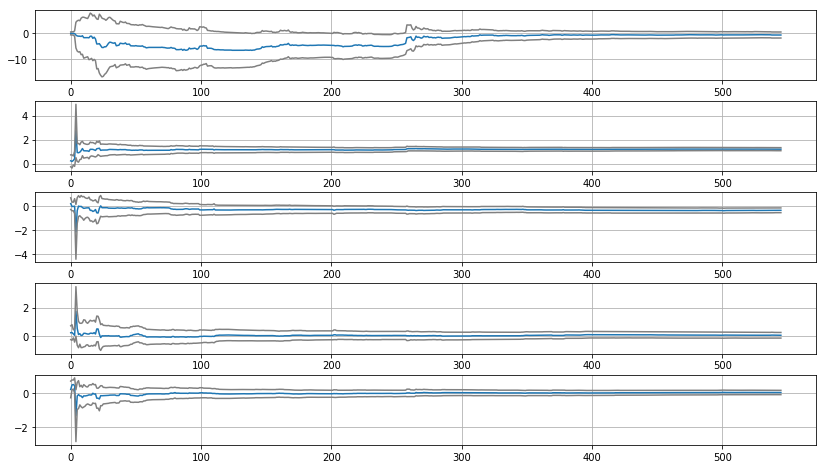

In [7]:
plt.figure(figsize=(14, 2*ARorder))
for i in range(ARorder+1):
    plt.subplot(ARorder+1, 1, i+1)
    plt.plot(Ebeta_log[:,i])
    plt.plot(Ebeta_log[:,i] + 3*np.sqrt(varbeta_log[:,i]), 'gray')
    plt.plot(Ebeta_log[:,i] - 3*np.sqrt(varbeta_log[:,i]), 'gray')
plt.show()

Totéž uděláme s odhadem variance šumu `Esigma2_log` a jaho variancí `varsigma2_log`.

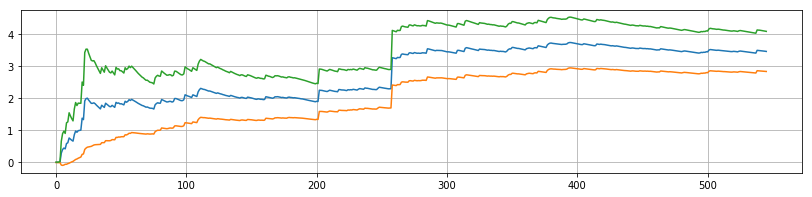

In [8]:
plt.figure(figsize=(14,3))
plt.plot(Esigma2_log)
plt.plot(Esigma2_log - 3*np.sqrt(varsigma2_log))
plt.plot(Esigma2_log + 3*np.sqrt(varsigma2_log))

Nakonec se podíváme na to nejzajímavější - jak si stály predikce ve srovnání se skutečností a určíme RMSE, střední kvadratickou chybu predikce 

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (X_i - \hat{X_i})^2}.
$$

Na závěr vykreslíme histogram reziduí.

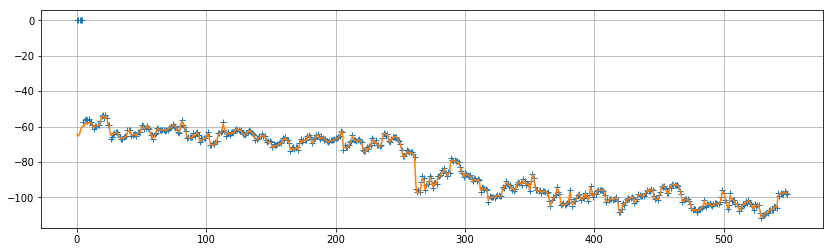

RMSE:  0.5169778429161979


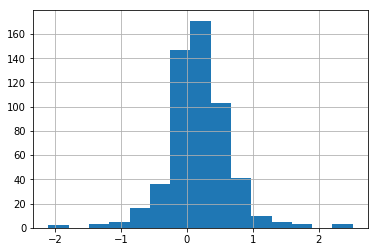

In [9]:
plt.figure(figsize=(14, 4))
plt.plot(pred, '+')
plt.plot(data)
plt.show()
residues = pred[ARorder+1:] - data[ARorder+1:]
print("RMSE: ", np.sqrt(np.mean(residues**2)))
plt.hist(residues, bins=15)
plt.show()